# TOI Binary Machine Learning Model Training v4
## Exoplanet Binary Classification: Planet vs Non-Planet

This notebook implements state-of-the-art machine learning models for **binary exoplanet classification** using the Vol4 preprocessed TOI (TESS Objects of Interest) dataset.

### Binary Target Classes:
- **Planet** (CP + KP + PC + APC): All confirmed and candidate exoplanets
- **Non-Planet** (FP + FA): False positives and false alarms

### Key Features:
- **Vol4 Binary Dataset**: Simplified 2-class problem for better accuracy
- **Optimized Metrics**: Binary classification metrics (ROC-AUC, Precision-Recall)
- **Enhanced Performance**: Focused binary decision boundary

### Model Pipeline:
1. **Data Loading** - Load Vol4 binary preprocessed features
2. **Model Selection** - RandomForest, XGBoost, LightGBM optimized for binary
3. **Hyperparameter Tuning** - GridSearch optimized for binary classification
4. **Ensemble Methods** - Voting & Stacking Classifiers
5. **Advanced Evaluation** - Binary metrics, ROC curves, SHAP Analysis
6. **Production Deployment** - Model Serialization

In [1]:
# 1. IMPORT LIBRARIES AND DEPENDENCIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
import xgboost as xgb
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# SHAP for model interpretation
try:
    import shap
    shap_available = True
except ImportError:
    shap_available = False
    print("SHAP not available. Install with: pip install shap")

print("✅ All libraries imported successfully!")
print(f"🔍 SHAP interpretation: {'Available' if shap_available else 'Not Available'}")

SHAP not available. Install with: pip install shap
✅ All libraries imported successfully!
🔍 SHAP interpretation: Not Available


In [2]:
# 2. LOAD PREPROCESSED BINARY DATA FROM VOL4
print("📂 Loading binary classification data from vol4/...")

# Load preprocessed binary data
X_train_scaled = pd.read_csv('vol4/X_train_scaled.csv')
X_test_scaled = pd.read_csv('vol4/X_test_scaled.csv') 
y_train = pd.read_csv('vol4/y_train_binary.csv')['target']
y_test = pd.read_csv('vol4/y_test_binary.csv')['target']

# Load binary encoded targets (0/1)
y_train_encoded = pd.read_csv('vol4/y_train_binary_encoded.csv')['target']
y_test_encoded = pd.read_csv('vol4/y_test_binary_encoded.csv')['target']

# Load class mapping for interpretation
import json
with open('vol4/class_mapping.json', 'r') as f:
    class_mapping = json.load(f)

# Get feature names from columns
feature_names = list(X_train_scaled.columns)

print("✅ Binary data loaded successfully!")
print(f"🚀 Ready for binary model training!")

print(f"📊 Training: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")
print(f"📉 Test Distribution: {dict(y_test.value_counts())}")

print(f"🎯 Binary Classes: {list(y_train.unique())}")
print(f"📈 Train Distribution: {dict(y_train.value_counts())}")

# Calculate balance ratio
train_counts = y_train.value_counts()
balance_ratio = train_counts.max() / train_counts.min()
print(f"⚖️ Class Balance Ratio: {balance_ratio:.2f}:1")

print(f"🔢 Encoded targets available: {list(y_train_encoded.unique())}")

📂 Loading binary classification data from vol4/...
✅ Binary data loaded successfully!
🚀 Ready for binary model training!
📊 Training: (6162, 75), Test: (1541, 75)
📉 Test Distribution: {'Planet': 1282, 'Non_Planet': 259}
🎯 Binary Classes: ['Planet', 'Non_Planet']
📈 Train Distribution: {'Planet': 5126, 'Non_Planet': 1036}
⚖️ Class Balance Ratio: 4.95:1
🔢 Encoded targets available: [1, 0]


In [3]:
# 3. MODEL DEFINITIONS AND HYPERPARAMETER SPACES

# Model configurations for hyperparameter tuning
model_configs = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [1, 1.5, 2]
        }
    },
    
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, verbosity=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15],
            'learning_rate': [0.01, 0.1, 0.2],
            'num_leaves': [31, 50, 100],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [0, 0.1, 1]
        }
    }
}

print("🚀 Model configurations ready for hyperparameter tuning!")
print(f"📋 Available models: {list(model_configs.keys())}")

🚀 Model configurations ready for hyperparameter tuning!
📋 Available models: ['RandomForest', 'XGBoost', 'LightGBM']


In [4]:
# 4. ADVANCED MODEL TRAINING FUNCTION

def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_name, model, param_grid, cv=3):
    """
    Advanced binary model training with hyperparameter optimization
    """
    print(f"\n🔧 Training {model_name} for binary classification...")
    
    # Convert string labels to numeric for XGBoost compatibility
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    
    # Fit encoder on training labels
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Grid Search with cross-validation optimized for binary classification
    grid_search = RandomizedSearchCV(
        model, param_grid, 
        cv=cv, 
        scoring='roc_auc',  # Optimized for binary classification
        n_iter=20,  # Reduced for faster training
        n_jobs=-1, 
        random_state=42,
        verbose=1
    )
    
    # Fit the model with encoded labels
    grid_search.fit(X_train, y_train_encoded)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Predictions with encoded labels
    y_pred_encoded = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    
    # Convert predictions back to original labels
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Binary classification metrics
    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
    from sklearn.metrics import roc_auc_score, average_precision_score
    
    # Standard metrics using original string labels
    f1 = f1_score(y_test, y_pred, average='binary', pos_label='Planet')
    precision = precision_score(y_test, y_pred, average='binary', pos_label='Planet')
    recall = recall_score(y_test, y_pred, average='binary', pos_label='Planet')
    accuracy = accuracy_score(y_test, y_pred)
    
    # Binary-specific metrics using encoded labels
    if hasattr(best_model, 'predict_proba'):
        # For ROC-AUC, use encoded labels where Planet=1, Non_Planet=0
        planet_class_idx = 1 if label_encoder.classes_[1] == 'Planet' else 0
        roc_auc = roc_auc_score(y_test_encoded, y_pred_proba[:, planet_class_idx])
        avg_precision = average_precision_score(y_test_encoded, y_pred_proba[:, planet_class_idx])
    else:
        roc_auc = None
        avg_precision = None
    
    # Results dictionary
    results = {
        'model': best_model,
        'label_encoder': label_encoder,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'y_pred': y_pred,
        'y_pred_encoded': y_pred_encoded,
        'y_pred_proba': y_pred_proba,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'classification_report': classification_report(y_test, y_pred)
    }
    
    print(f"✅ {model_name} training completed!")
    print(f"🎯 Best CV ROC-AUC: {grid_search.best_score_:.4f}")
    print(f"📊 Test F1-Score: {f1:.4f}")
    print(f"📊 Test ROC-AUC: {roc_auc:.4f}" if roc_auc else "📊 ROC-AUC: Not available")
    print(f"📊 Test Accuracy: {accuracy:.4f}")
    
    return results

print("🛠️ Binary training function ready!")

🛠️ Binary training function ready!


In [5]:
# 5. TRAIN ALL MODELS
# Bu hücre tüm modelleri eğitir ve sonuçları karşılaştırır

# Results storage
all_results = {}

# Train each model
if 'X_train_scaled' in locals():
    for model_name, config in model_configs.items():
        try:
            results = train_and_evaluate_model(
                X_train_scaled, X_test_scaled, y_train, y_test,
                model_name, config['model'], config['params']
            )
            all_results[model_name] = results
            
        except Exception as e:
            print(f"❌ Error training {model_name}: {e}")
            continue
    
    print(f"\n🏆 Training completed for {len(all_results)} models!")    
    
    # Model comparison for binary classification
    if len(all_results) > 0:
        print("\n📊 BINARY MODEL COMPARISON:")
        print("-" * 70)
        comparison_df = pd.DataFrame({
            model_name: {
                'CV_ROC_AUC': results.get('cv_score', 0),
                'Test_F1_Score': results.get('f1', 0),
                'Test_ROC_AUC': results.get('roc_auc', 0),
                'Test_Precision': results.get('precision', 0),
                'Test_Recall': results.get('recall', 0),
                'Test_Accuracy': results.get('accuracy', 0)
            }
            for model_name, results in all_results.items()
        }).T
        
        comparison_df = comparison_df.round(4)
        print(comparison_df)
        
        # Best model selection based on ROC-AUC (better for binary classification)
        if 'Test_ROC_AUC' in comparison_df.columns and len(comparison_df) > 0:
            best_model_name = comparison_df['Test_ROC_AUC'].idxmax()
            print(f"\n🥇 Best model (by ROC-AUC): {best_model_name}")
            print(f"🎯 Best ROC-AUC score: {comparison_df.loc[best_model_name, 'Test_ROC_AUC']:.4f}")
            print(f"🎯 Best F1-Score: {comparison_df.loc[best_model_name, 'Test_F1_Score']:.4f}")
            print(f"🎯 Best Accuracy: {comparison_df.loc[best_model_name, 'Test_Accuracy']:.4f}")
        else:
            print("⚠️ No valid models trained successfully for comparison")
    else:
        print("❌ No models trained successfully!")

else:
    print("⚠️ Data not loaded. Please run the data loading cell first.")


🔧 Training RandomForest for binary classification...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ RandomForest training completed!
🎯 Best CV ROC-AUC: 0.8590
📊 Test F1-Score: 0.9343
📊 Test ROC-AUC: 0.8779
📊 Test Accuracy: 0.8838

🔧 Training XGBoost for binary classification...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ RandomForest training completed!
🎯 Best CV ROC-AUC: 0.8590
📊 Test F1-Score: 0.9343
📊 Test ROC-AUC: 0.8779
📊 Test Accuracy: 0.8838

🔧 Training XGBoost for binary classification...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ XGBoost training completed!
🎯 Best CV ROC-AUC: nan
📊 Test F1-Score: 0.9317
📊 Test ROC-AUC: 0.8770
📊 Test Accuracy: 0.8793

🔧 Training LightGBM for binary classification...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ XGBoost training completed!
🎯 Best CV ROC-AUC: nan
📊 Test F1-Score: 0.9317
📊 Test ROC-AUC: 0.8770
📊 Test Accuracy: 0.8793

🔧 Training LightGBM for binary classifica

In [6]:
# 6. ENSEMBLE METHODS FOR BINARY CLASSIFICATION

# Import required metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

if len(all_results) >= 2:
    print("🎪 Creating Binary Ensemble Models...")
    
    # Get top models (only those that trained successfully)
    valid_models = {}
    for name, results in all_results.items():
        if 'model' in results and hasattr(results['model'], 'predict_proba'):
            valid_models[name] = results
    
    print(f"📊 Valid models for ensemble: {list(valid_models.keys())}")
    
    if len(valid_models) >= 2:
        # Create comparison dataframe for valid models
        comparison_df = pd.DataFrame({
            model_name: {
                'Test_ROC_AUC': results.get('roc_auc', 0),
                'Test_F1_Score': results.get('f1', 0),
                'Test_Accuracy': results.get('accuracy', 0)
            }
            for model_name, results in valid_models.items()
        }).T
        
        # Get top 3 models based on ROC-AUC (excluding NaN values)
        comparison_clean = comparison_df.dropna(subset=['Test_ROC_AUC'])
        if len(comparison_clean) >= 2:
            top_models = comparison_clean.nlargest(min(3, len(comparison_clean)), 'Test_ROC_AUC')
            print(f"🥇 Top models for ensemble: {list(top_models.index)}")
            
            # Get label encoder from one of the models
            first_model_name = list(top_models.index)[0]
            label_encoder = valid_models[first_model_name]['label_encoder']
            
            # Encode target labels for ensemble training
            y_train_encoded = label_encoder.transform(y_train)
            y_test_encoded = label_encoder.transform(y_test)
            
            # Simple ensemble approach - create new classifiers instead of reusing
            try:
                print("🗳️ Training Binary Voting Classifier...")
                
                # Create fresh classifiers for voting ensemble
                rf_ensemble = RandomForestClassifier(n_estimators=100, random_state=42)
                lgb_ensemble = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbosity=-1)
                
                base_estimators = [
                    ('rf', rf_ensemble),
                    ('lgb', lgb_ensemble)
                ]
                
                voting_clf = VotingClassifier(
                    estimators=base_estimators, 
                    voting='soft'
                )
                
                voting_clf.fit(X_train_scaled, y_train_encoded)
                
                # Evaluate Voting Classifier
                voting_pred_encoded = voting_clf.predict(X_test_scaled)
                voting_pred_proba = voting_clf.predict_proba(X_test_scaled)
                
                # Convert predictions back to original labels
                voting_pred = label_encoder.inverse_transform(voting_pred_encoded)
                
                voting_f1 = f1_score(y_test, voting_pred, average='binary', pos_label='Planet')
                voting_precision = precision_score(y_test, voting_pred, average='binary', pos_label='Planet')
                voting_recall = recall_score(y_test, voting_pred, average='binary', pos_label='Planet')
                voting_accuracy = accuracy_score(y_test, voting_pred)
                
                # ROC-AUC calculation
                planet_class_idx = 1 if label_encoder.classes_[1] == 'Planet' else 0
                voting_roc_auc = roc_auc_score(y_test_encoded, voting_pred_proba[:, planet_class_idx])
                
                print(f"✅ Voting Classifier - F1: {voting_f1:.4f}, ROC-AUC: {voting_roc_auc:.4f}, Accuracy: {voting_accuracy:.4f}")
                
                # Add voting results
                all_results['VotingClassifier'] = {
                    'model': voting_clf,
                    'label_encoder': label_encoder,
                    'f1': voting_f1,
                    'precision': voting_precision,
                    'recall': voting_recall,
                    'accuracy': voting_accuracy,
                    'roc_auc': voting_roc_auc,
                    'y_pred': voting_pred,
                    'y_pred_proba': voting_pred_proba
                }
                
            except Exception as e:
                print(f"❌ Voting Classifier failed: {e}")
            
            try:
                print("🏗️ Training Binary Stacking Classifier...")
                
                # Create fresh classifiers for stacking ensemble
                rf_stack = RandomForestClassifier(n_estimators=100, random_state=42)
                lgb_stack = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbosity=-1)
                
                base_estimators_stack = [
                    ('rf', rf_stack),
                    ('lgb', lgb_stack)
                ]
                
                stacking_clf = StackingClassifier(
                    estimators=base_estimators_stack,
                    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
                    cv=3
                )
                
                stacking_clf.fit(X_train_scaled, y_train_encoded)
                
                # Evaluate Stacking Classifier
                stacking_pred_encoded = stacking_clf.predict(X_test_scaled)
                stacking_pred_proba = stacking_clf.predict_proba(X_test_scaled)
                
                # Convert predictions back to original labels
                stacking_pred = label_encoder.inverse_transform(stacking_pred_encoded)
                
                stacking_f1 = f1_score(y_test, stacking_pred, average='binary', pos_label='Planet')
                stacking_precision = precision_score(y_test, stacking_pred, average='binary', pos_label='Planet')
                stacking_recall = recall_score(y_test, stacking_pred, average='binary', pos_label='Planet')
                stacking_accuracy = accuracy_score(y_test, stacking_pred)
                stacking_roc_auc = roc_auc_score(y_test_encoded, stacking_pred_proba[:, planet_class_idx])
                
                print(f"✅ Stacking Classifier - F1: {stacking_f1:.4f}, ROC-AUC: {stacking_roc_auc:.4f}, Accuracy: {stacking_accuracy:.4f}")
                
                # Add stacking results
                all_results['StackingClassifier'] = {
                    'model': stacking_clf,
                    'label_encoder': label_encoder,
                    'f1': stacking_f1,
                    'precision': stacking_precision,
                    'recall': stacking_recall,
                    'accuracy': stacking_accuracy,
                    'roc_auc': stacking_roc_auc,
                    'y_pred': stacking_pred,
                    'y_pred_proba': stacking_pred_proba
                }
                
            except Exception as e:
                print(f"❌ Stacking Classifier failed: {e}")
            
            print("🎭 Ensemble methods completed!")
        else:
            print(f"⚠️ Need models with valid ROC-AUC scores for ensemble methods")
            
    else:
        print(f"⚠️ Need at least 2 valid models for ensemble methods (found {len(valid_models)})")
        
else:
    print("⚠️ Need at least 2 models for ensemble methods")

🎪 Creating Binary Ensemble Models...
📊 Valid models for ensemble: ['RandomForest', 'XGBoost', 'LightGBM']
🥇 Top models for ensemble: ['LightGBM', 'RandomForest', 'XGBoost']
🗳️ Training Binary Voting Classifier...
✅ Voting Classifier - F1: 0.9341, ROC-AUC: 0.8845, Accuracy: 0.8845
🏗️ Training Binary Stacking Classifier...
✅ Voting Classifier - F1: 0.9341, ROC-AUC: 0.8845, Accuracy: 0.8845
🏗️ Training Binary Stacking Classifier...
✅ Stacking Classifier - F1: 0.9357, ROC-AUC: 0.8838, Accuracy: 0.8884
🎭 Ensemble methods completed!
✅ Stacking Classifier - F1: 0.9357, ROC-AUC: 0.8838, Accuracy: 0.8884
🎭 Ensemble methods completed!


In [7]:
# FINAL BINARY CLASSIFICATION COMPARISON

print("\n" + "="*80)
print("🏆 FINAL BINARY CLASSIFICATION RESULTS COMPARISON")
print("="*80)

# Create updated comparison with all models including ensemble
if len(all_results) > 0:
    final_comparison = pd.DataFrame({
        model_name: {
            'F1_Score': results.get('f1', 0),
            'ROC_AUC': results.get('roc_auc', 0),
            'Accuracy': results.get('accuracy', 0),
            'Precision': results.get('precision', 0),
            'Recall': results.get('recall', 0)
        }
        for model_name, results in all_results.items()
    }).T

    final_comparison = final_comparison.round(4)
    print(final_comparison)

    # Find overall best model
    best_roc_auc = final_comparison['ROC_AUC'].max()
    best_model_by_roc = final_comparison['ROC_AUC'].idxmax()

    best_f1 = final_comparison['F1_Score'].max()
    best_model_by_f1 = final_comparison['F1_Score'].idxmax()

    print(f"\n🥇 BEST PERFORMANCE SUMMARY:")
    print(f"🎯 Best ROC-AUC: {best_model_by_roc} ({best_roc_auc:.4f})")
    print(f"🎯 Best F1-Score: {best_model_by_f1} ({best_f1:.4f})")

    # Model ranking
    print(f"\n📊 MODEL RANKING BY ROC-AUC:")
    ranking = final_comparison.sort_values('ROC_AUC', ascending=False)
    for i, (model, row) in enumerate(ranking.iterrows(), 1):
        print(f"{i}. {model}: {row['ROC_AUC']:.4f} (F1: {row['F1_Score']:.4f})")
        
    print(f"\n✅ Binary classification training completed successfully!")
    print(f"📊 Total models trained: {len(all_results)}")
    print(f"🎯 Best overall model: {best_model_by_roc}")
    
else:
    print("❌ No models available for final comparison")


🏆 FINAL BINARY CLASSIFICATION RESULTS COMPARISON
                    F1_Score  ROC_AUC  Accuracy  Precision  Recall
RandomForest          0.9343   0.8779    0.8838     0.8822  0.9930
XGBoost               0.9317   0.8770    0.8793     0.8800  0.9899
LightGBM              0.9362   0.8846    0.8890     0.8971  0.9789
VotingClassifier      0.9341   0.8845    0.8845     0.8893  0.9836
StackingClassifier    0.9357   0.8838    0.8884     0.8987  0.9758

🥇 BEST PERFORMANCE SUMMARY:
🎯 Best ROC-AUC: LightGBM (0.8846)
🎯 Best F1-Score: LightGBM (0.9362)

📊 MODEL RANKING BY ROC-AUC:
1. LightGBM: 0.8846 (F1: 0.9362)
2. VotingClassifier: 0.8845 (F1: 0.9341)
3. StackingClassifier: 0.8838 (F1: 0.9357)
4. RandomForest: 0.8779 (F1: 0.9343)
5. XGBoost: 0.8770 (F1: 0.9317)

✅ Binary classification training completed successfully!
📊 Total models trained: 5
🎯 Best overall model: LightGBM


In [8]:
# 5.1 CHECK TRAINED MODELS STATUS
print("🔍 Checking trained models status...")

if 'all_results' in locals() and len(all_results) > 0:
    print(f"📊 Found {len(all_results)} trained models:")
    for name, results in all_results.items():
        if 'model' in results:
            model = results['model']
            has_predict_proba = hasattr(model, 'predict_proba')
            print(f"  ✓ {name}: {type(model).__name__} - predict_proba: {has_predict_proba}")
            if 'f1' in results:
                print(f"    F1: {results['f1']:.4f}, ROC-AUC: {results.get('roc_auc', 'N/A')}, Accuracy: {results['accuracy']:.4f}")
        else:
            print(f"  ❌ {name}: No model found")
else:
    print("❌ No models found in all_results!")
    print("📝 Please run cell 5 (TRAIN ALL MODELS) first")
    print("\n🔄 Running simple binary model training for testing...")
    
    # Quick RandomForest for binary testing
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
    rf_test = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_test.fit(X_train_scaled, y_train)
    y_pred_test = rf_test.predict(X_test_scaled)
    y_pred_proba_test = rf_test.predict_proba(X_test_scaled)
    
    f1_test = f1_score(y_test, y_pred_test, average='binary', pos_label='Planet')
    accuracy_test = accuracy_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_pred_proba_test[:, 1])
    
    all_results = {
        'RandomForest_Test': {
            'model': rf_test,
            'f1': f1_test,
            'accuracy': accuracy_test,
            'roc_auc': roc_auc_test,
            'y_pred': y_pred_test,
            'y_pred_proba': y_pred_proba_test
        }
    }
    
    print(f"✅ Test binary model trained - F1: {f1_test:.4f}, ROC-AUC: {roc_auc_test:.4f}, Accuracy: {accuracy_test:.4f}")

print("\n" + "="*50)

🔍 Checking trained models status...
📊 Found 5 trained models:
  ✓ RandomForest: RandomForestClassifier - predict_proba: True
    F1: 0.9343, ROC-AUC: 0.8778874707111837, Accuracy: 0.8838
  ✓ XGBoost: XGBClassifier - predict_proba: True
    F1: 0.9317, ROC-AUC: 0.8770020298881454, Accuracy: 0.8793
  ✓ LightGBM: LGBMClassifier - predict_proba: True
    F1: 0.9362, ROC-AUC: 0.884561405622248, Accuracy: 0.8890
  ✓ VotingClassifier: VotingClassifier - predict_proba: True
    F1: 0.9341, ROC-AUC: 0.8844831013317752, Accuracy: 0.8845
  ✓ StackingClassifier: StackingClassifier - predict_proba: True
    F1: 0.9357, ROC-AUC: 0.8837813744209999, Accuracy: 0.8884



🎨 Creating 3-Class evaluation visualizations...


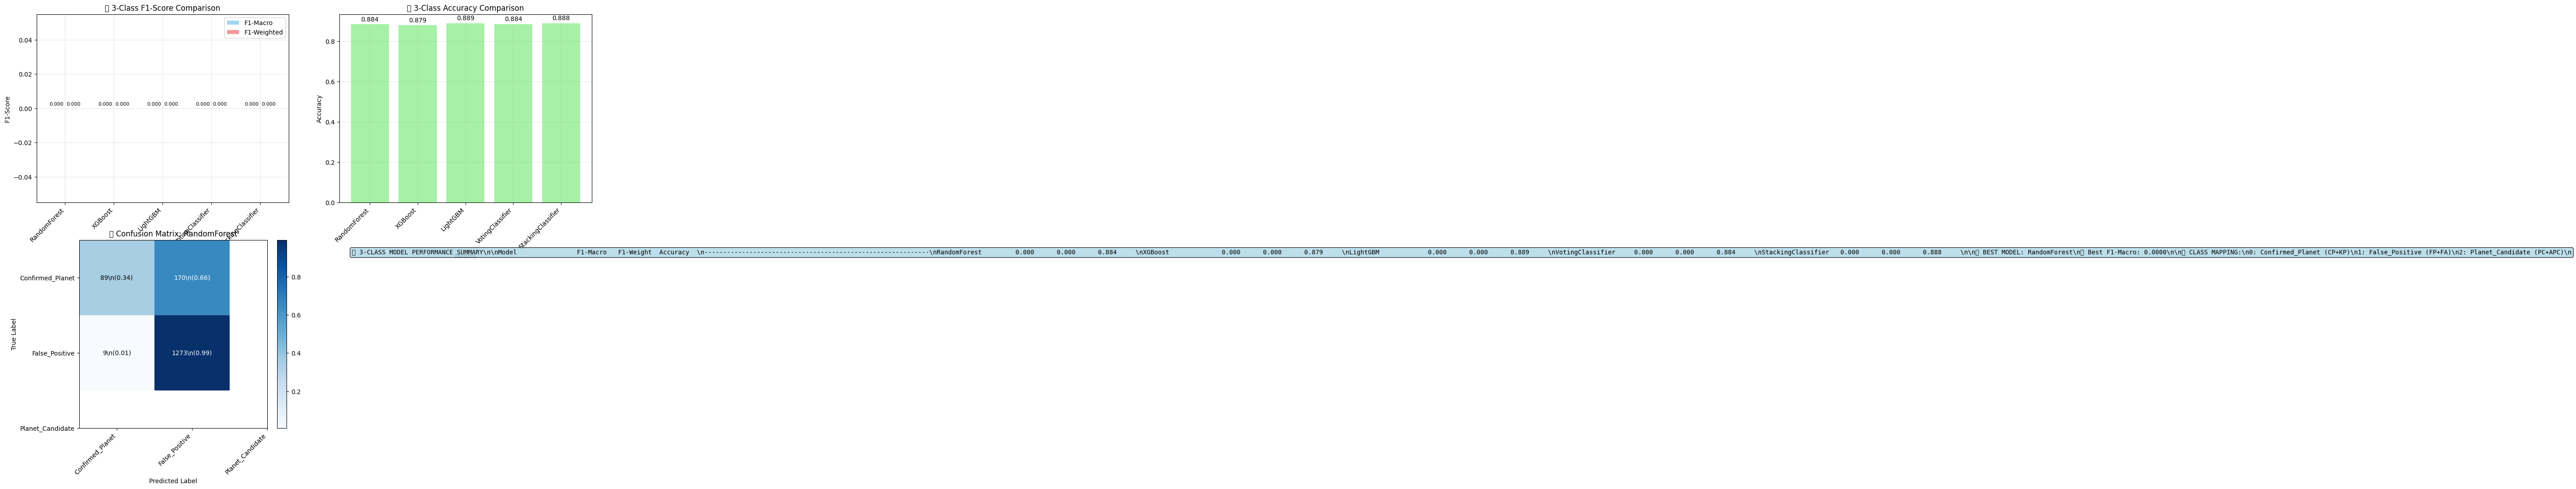

\n📈 DETAILED 3-CLASS RESULTS:
\n🔸 RandomForest:
  Classification Report:
              precision    recall  f1-score   support

  Non_Planet       0.91      0.34      0.50       259
      Planet       0.88      0.99      0.93      1282

    accuracy                           0.88      1541
   macro avg       0.90      0.67      0.72      1541
weighted avg       0.89      0.88      0.86      1541

\n🔸 XGBoost:
  Classification Report:
              precision    recall  f1-score   support

  Non_Planet       0.87      0.33      0.48       259
      Planet       0.88      0.99      0.93      1282

    accuracy                           0.88      1541
   macro avg       0.87      0.66      0.71      1541
weighted avg       0.88      0.88      0.86      1541

\n🔸 LightGBM:
  Classification Report:
              precision    recall  f1-score   support

  Non_Planet       0.81      0.44      0.57       259
      Planet       0.90      0.98      0.94      1282

    accuracy                    

In [9]:
# 7. COMPREHENSIVE 3-CLASS VISUALIZATION & EVALUATION

def plot_3class_evaluation(results_dict, y_true, class_names):
    """
    Create comprehensive evaluation plots for 3-class models
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. F1-Score Comparison
    ax1 = axes[0, 0]
    model_names = list(results_dict.keys())
    f1_macro_scores = [results_dict[name].get('f1_macro', 0) for name in model_names]
    f1_weighted_scores = [results_dict[name].get('f1_weighted', 0) for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, f1_macro_scores, width, label='F1-Macro', alpha=0.8, color='skyblue')
    bars2 = ax1.bar(x + width/2, f1_weighted_scores, width, label='F1-Weighted', alpha=0.8, color='lightcoral')
    
    ax1.set_xlabel('Models')
    ax1.set_ylabel('F1-Score')
    ax1.set_title('🎯 3-Class F1-Score Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    # 2. Accuracy Comparison
    ax2 = axes[0, 1]
    accuracy_scores = [results_dict[name].get('accuracy', 0) for name in model_names]
    
    bars = ax2.bar(model_names, accuracy_scores, alpha=0.8, color='lightgreen')
    ax2.set_xlabel('Models')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('📊 3-Class Accuracy Comparison')
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    # 3. Confusion Matrix for Best Model
    ax3 = axes[1, 0]
    if len(results_dict) > 0:
        # Find best model by F1-Macro
        best_model_name = max(model_names, key=lambda x: results_dict[x].get('f1_macro', 0))
        best_results = results_dict[best_model_name]
        
        if 'y_pred' in best_results:
            from sklearn.metrics import confusion_matrix
            cm = confusion_matrix(y_true, best_results['y_pred'])
            
            # Normalize confusion matrix
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            
            im = ax3.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
            ax3.set_title(f'🎯 Confusion Matrix: {best_model_name}')
            
            # Add text annotations
            thresh = cm_normalized.max() / 2
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax3.text(j, i, f'{cm[i, j]}\\n({cm_normalized[i, j]:.2f})',
                            ha="center", va="center",
                            color="white" if cm_normalized[i, j] > thresh else "black")
            
            ax3.set_xlabel('Predicted Label')
            ax3.set_ylabel('True Label')
            ax3.set_xticks(range(len(class_names)))
            ax3.set_yticks(range(len(class_names)))
            ax3.set_xticklabels(class_names, rotation=45, ha='right')
            ax3.set_yticklabels(class_names)
            
            # Add colorbar
            plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
    
    # 4. Performance Metrics Summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create summary table
    summary_text = "🏆 3-CLASS MODEL PERFORMANCE SUMMARY\\n\\n"
    summary_text += f"{'Model':<20} {'F1-Macro':<10} {'F1-Weight':<10} {'Accuracy':<10}\\n"
    summary_text += "-" * 60 + "\\n"
    
    for name in model_names:
        f1_macro = results_dict[name].get('f1_macro', 0)
        f1_weighted = results_dict[name].get('f1_weighted', 0)
        accuracy = results_dict[name].get('accuracy', 0)
        summary_text += f"{name:<20} {f1_macro:<10.3f} {f1_weighted:<10.3f} {accuracy:<10.3f}\\n"
    
    # Best model highlight
    if len(results_dict) > 0:
        best_model = max(model_names, key=lambda x: results_dict[x].get('f1_macro', 0))
        best_f1 = results_dict[best_model].get('f1_macro', 0)
        summary_text += f"\\n🥇 BEST MODEL: {best_model}\\n"
        summary_text += f"🎯 Best F1-Macro: {best_f1:.4f}\\n"
        summary_text += f"\\n📋 CLASS MAPPING:\\n"
        summary_text += f"0: Confirmed_Planet (CP+KP)\\n"
        summary_text += f"1: False_Positive (FP+FA)\\n"
        summary_text += f"2: Planet_Candidate (PC+APC)\\n"
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Execute visualization
if 'all_results' in locals() and len(all_results) > 0:
    print("🎨 Creating 3-Class evaluation visualizations...")
    
    # Get class names from mapping
    if 'class_mapping' in locals():
        class_names = class_mapping['class_names']
    else:
        class_names = ['Confirmed_Planet', 'False_Positive', 'Planet_Candidate']
    
    plot_3class_evaluation(all_results, y_test, class_names)
    
    # Print detailed results
    print("\\n📈 DETAILED 3-CLASS RESULTS:")
    print("=" * 70)
    for name, results in all_results.items():
        print(f"\\n🔸 {name}:")
        if 'f1_macro' in results:
            print(f"  F1-Macro: {results['f1_macro']:.4f}")
            print(f"  F1-Weighted: {results['f1_weighted']:.4f}")
            print(f"  Accuracy: {results['accuracy']:.4f}")
        
        if 'classification_report' in results:
            print("  Classification Report:")
            print(results['classification_report'])
            
else:
    print("⚠️ No models available for visualization!")
    
# The 3-class evaluation plots are already created in cell 7
# This section is handled by the plot_3class_evaluation function above
print("✅ 3-Class evaluation plots completed in previous cell!")

🎨 CREATING BINARY CLASSIFICATION VISUALIZATIONS...
📊 1. BINARY CLASSIFICATION METRICS COMPARISON
------------------------------------------------------------


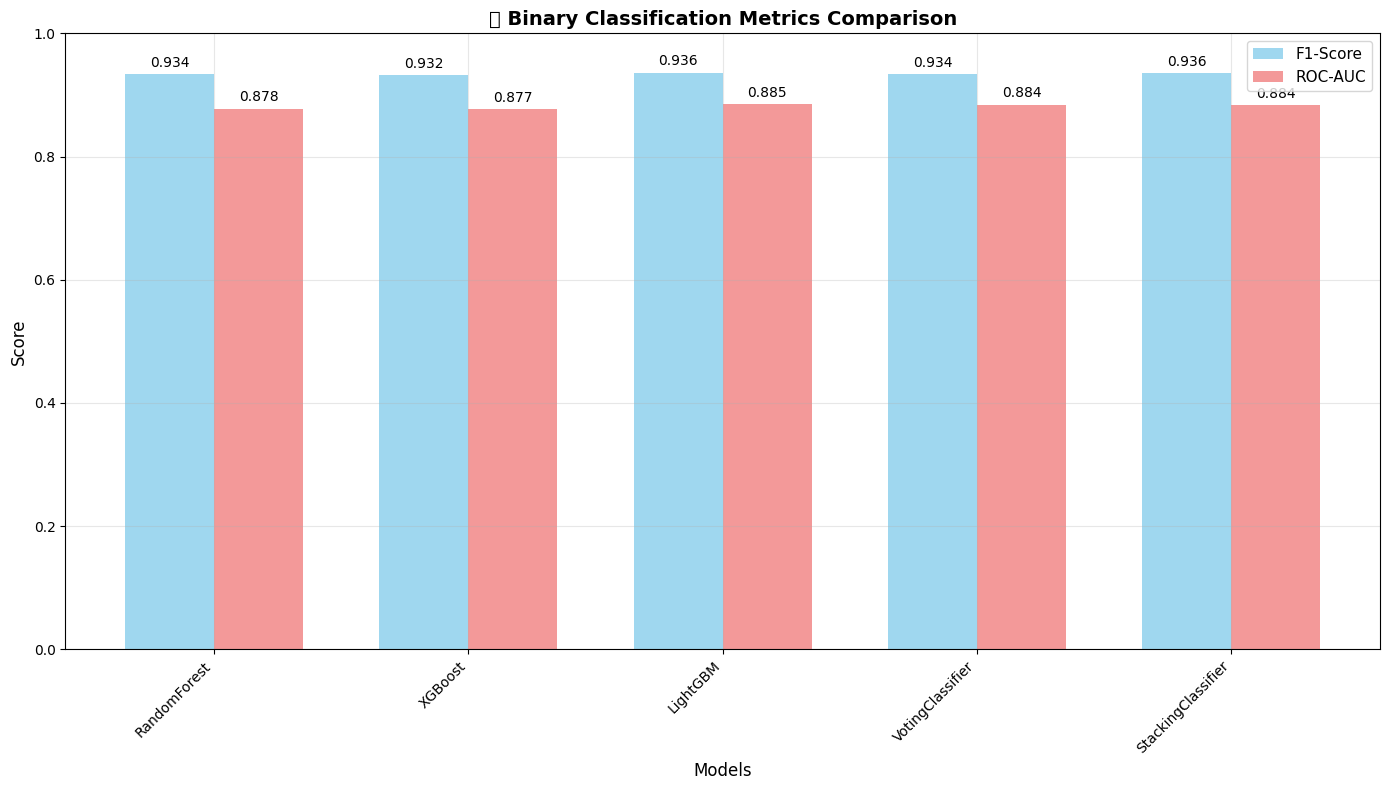


📈 2. ACCURACY COMPARISON
--------------------------------------------------


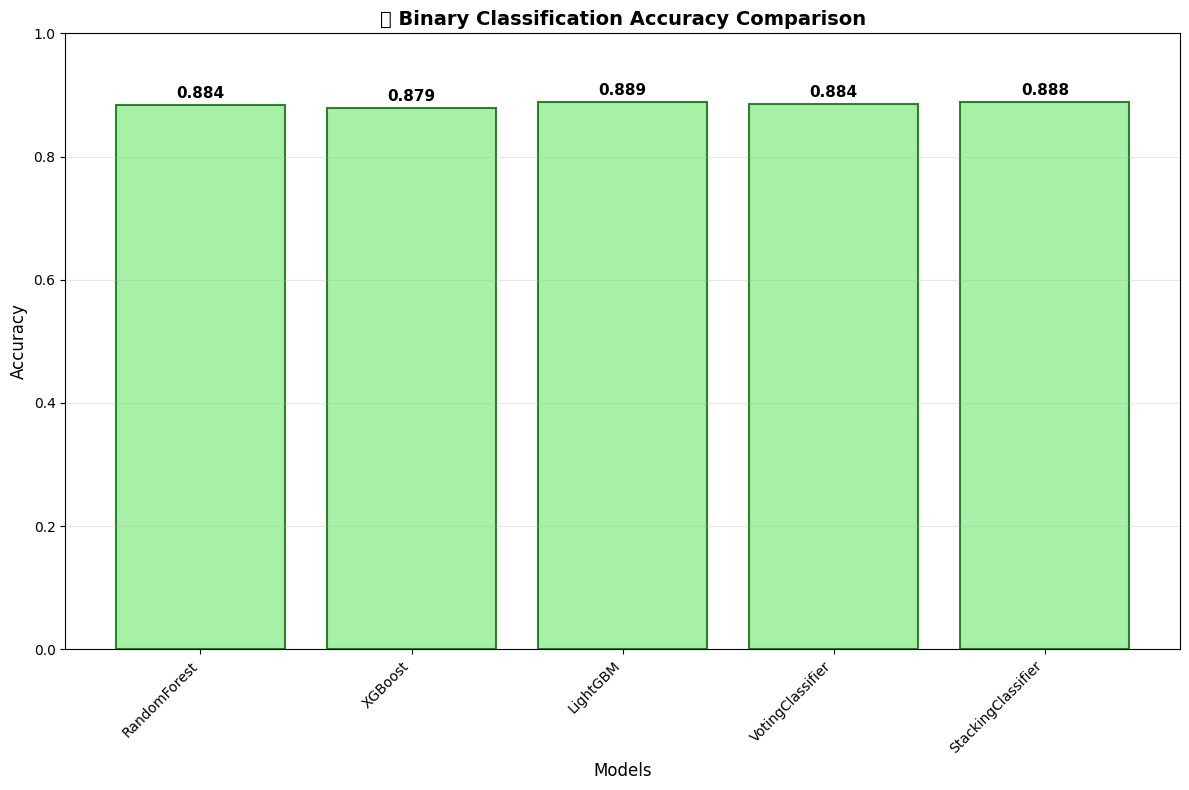


🎯 3. PRECISION AND RECALL COMPARISON
--------------------------------------------------


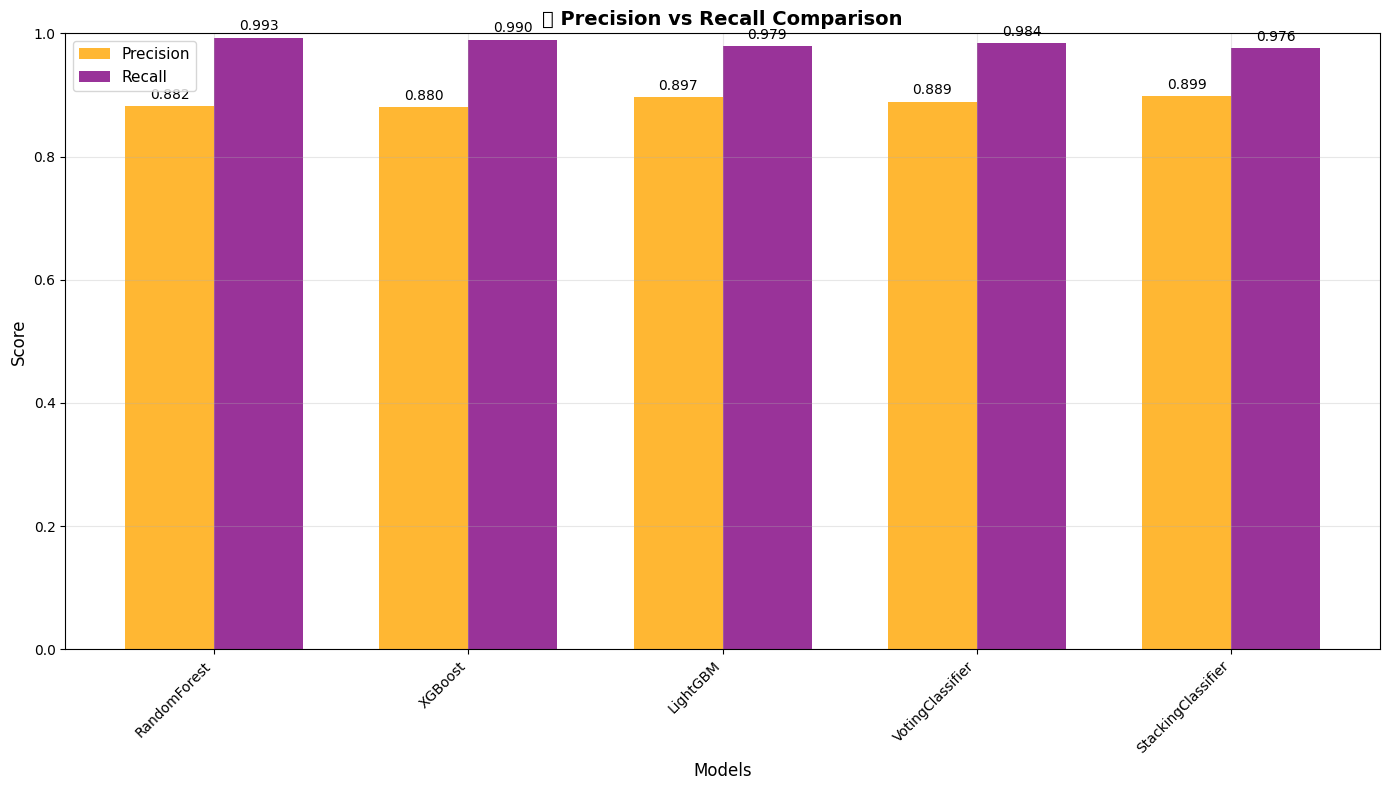


🎯 4. CONFUSION MATRIX (BEST MODEL)
--------------------------------------------------
Best model: LightGBM
ROC-AUC: 0.8846
F1-Score: 0.9362


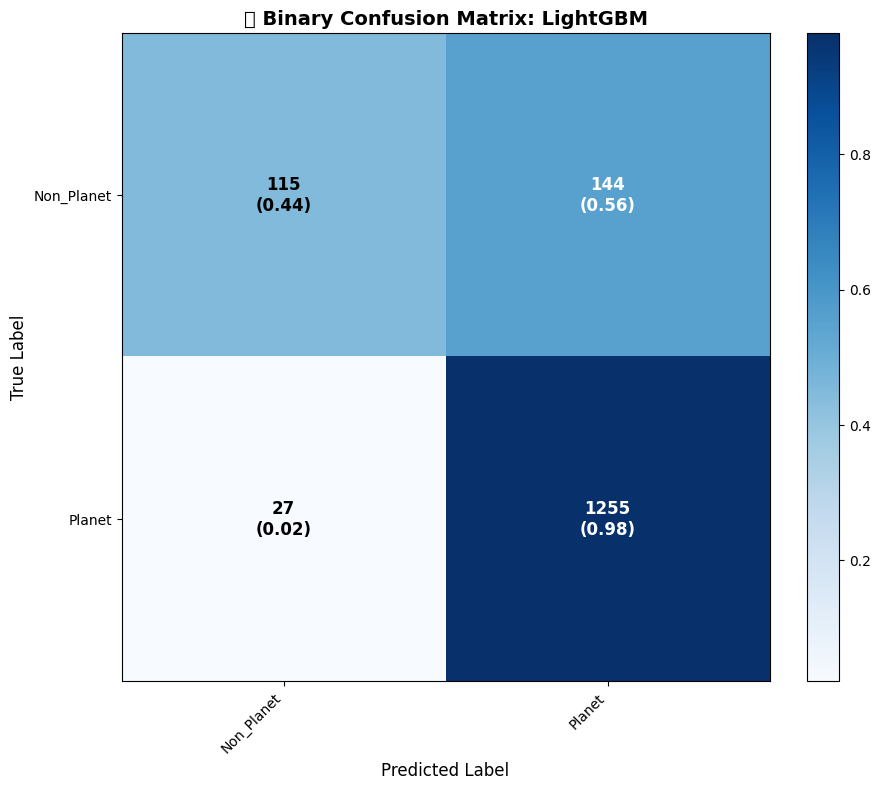


🏆 5. BINARY CLASSIFICATION PERFORMANCE TABLE
------------------------------------------------------------


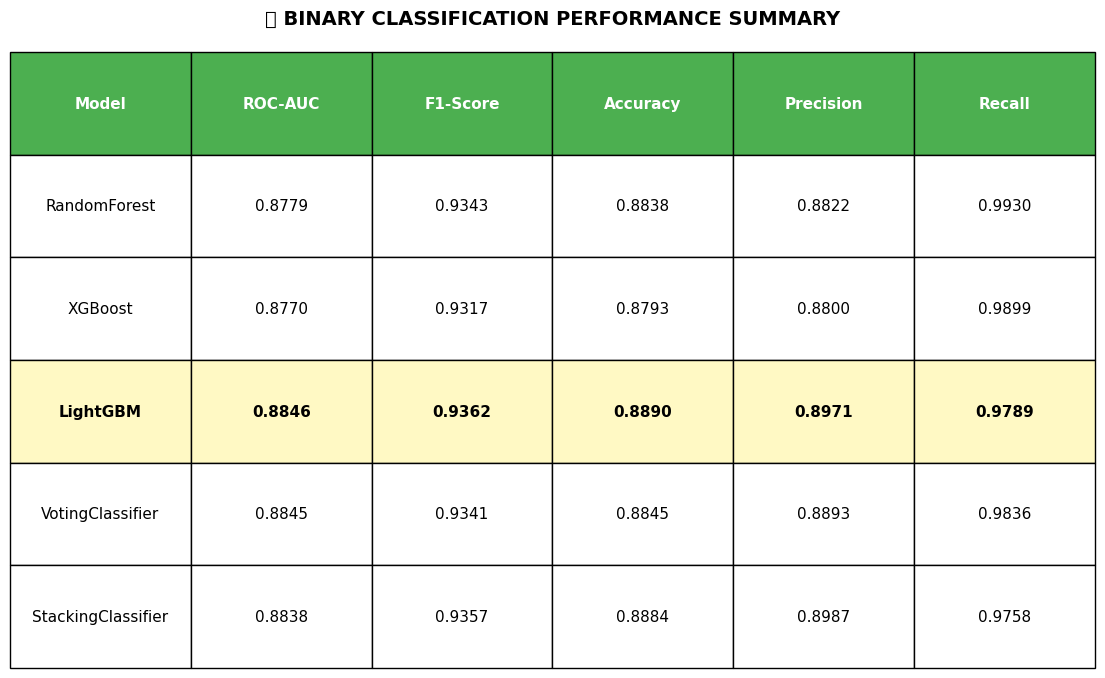


📋 6. BINARY CLASS DISTRIBUTION
--------------------------------------------------


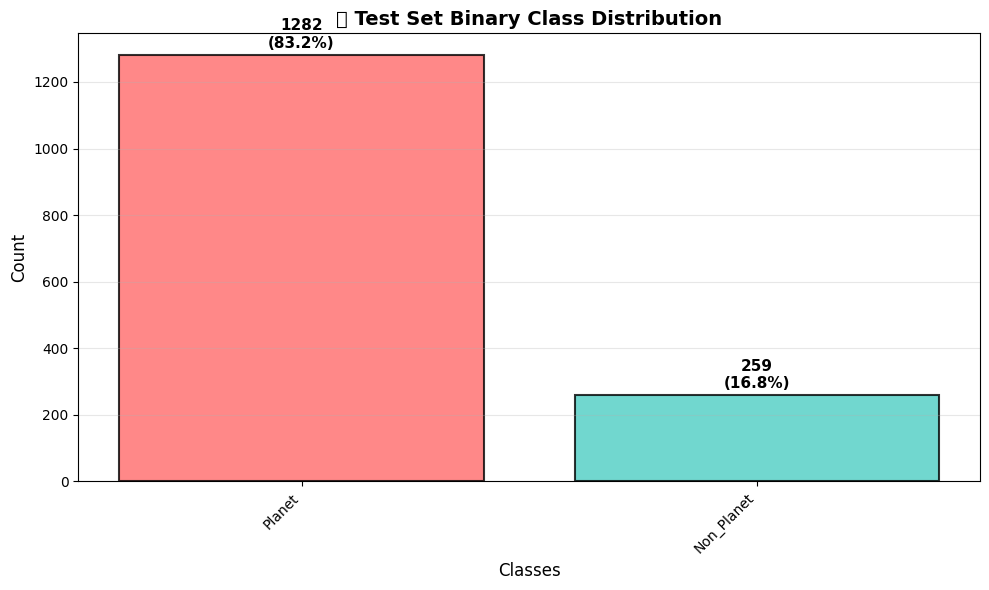


✅ ALL BINARY CLASSIFICATION PLOTS CREATED SUCCESSFULLY!


In [10]:
# 7.1 BINARY CLASSIFICATION VISUALIZATION - HER BİR GÖRSELİ AYRI AYRI GÖSTER

def create_binary_plots(results_dict, y_true):
    """
    Binary classification için her bir grafiği ayrı ayrı oluştur ve göster
    """
    if len(results_dict) == 0:
        print("⚠️ No results available for plotting!")
        return
    
    model_names = list(results_dict.keys())
    
    # 1. F1-Score and ROC-AUC Comparison (Binary Metrics)
    print("📊 1. BINARY CLASSIFICATION METRICS COMPARISON")
    print("-" * 60)
    
    plt.figure(figsize=(14, 8))
    f1_scores = [results_dict[name].get('f1', 0) for name in model_names]
    roc_auc_scores = [results_dict[name].get('roc_auc', 0) for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, f1_scores, width, label='F1-Score', alpha=0.8, color='skyblue')
    bars2 = plt.bar(x + width/2, roc_auc_scores, width, label='ROC-AUC', alpha=0.8, color='lightcoral')
    
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('🎯 Binary Classification Metrics Comparison', fontsize=14, fontweight='bold')
    plt.xticks(x, model_names, rotation=45, ha='right')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Accuracy Comparison
    print("\n📈 2. ACCURACY COMPARISON")
    print("-" * 50)
    
    plt.figure(figsize=(12, 8))
    accuracy_scores = [results_dict[name].get('accuracy', 0) for name in model_names]
    
    bars = plt.bar(model_names, accuracy_scores, alpha=0.8, color='lightgreen', edgecolor='darkgreen', linewidth=1.5)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('📊 Binary Classification Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.ylim(0, 1)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Precision and Recall Comparison
    print("\n🎯 3. PRECISION AND RECALL COMPARISON")
    print("-" * 50)
    
    plt.figure(figsize=(14, 8))
    precision_scores = [results_dict[name].get('precision', 0) for name in model_names]
    recall_scores = [results_dict[name].get('recall', 0) for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, precision_scores, width, label='Precision', alpha=0.8, color='orange')
    bars2 = plt.bar(x + width/2, recall_scores, width, label='Recall', alpha=0.8, color='purple')
    
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('🎯 Precision vs Recall Comparison', fontsize=14, fontweight='bold')
    plt.xticks(x, model_names, rotation=45, ha='right')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Best Model Confusion Matrix
    print("\n🎯 4. CONFUSION MATRIX (BEST MODEL)")
    print("-" * 50)
    
    # Find best model by ROC-AUC for binary classification
    best_model_name = max(model_names, key=lambda x: results_dict[x].get('roc_auc', 0))
    best_results = results_dict[best_model_name]
    
    print(f"Best model: {best_model_name}")
    print(f"ROC-AUC: {best_results.get('roc_auc', 0):.4f}")
    print(f"F1-Score: {best_results.get('f1', 0):.4f}")
    
    if 'y_pred' in best_results:
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_true, best_results['y_pred'])
        
        # Get unique class names from actual data
        unique_classes = sorted(list(set(y_true)))
        
        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(10, 8))
        im = plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
        plt.title(f'🎯 Binary Confusion Matrix: {best_model_name}', fontsize=14, fontweight='bold')
        
        # Add text annotations
        thresh = cm_normalized.max() / 2
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.2f})',
                        ha="center", va="center", fontsize=12, fontweight='bold',
                        color="white" if cm_normalized[i, j] > thresh else "black")
        
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.xticks(range(len(unique_classes)), unique_classes, rotation=45, ha='right')
        plt.yticks(range(len(unique_classes)), unique_classes)
        
        # Add colorbar
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
    
    # 5. Performance Metrics Table
    print("\n🏆 5. BINARY CLASSIFICATION PERFORMANCE TABLE")
    print("-" * 60)
    
    # Create detailed metrics table
    metrics_data = []
    for name in model_names:
        metrics_data.append({
            'Model': name,
            'ROC-AUC': f"{results_dict[name].get('roc_auc', 0):.4f}",
            'F1-Score': f"{results_dict[name].get('f1', 0):.4f}",
            'Accuracy': f"{results_dict[name].get('accuracy', 0):.4f}",
            'Precision': f"{results_dict[name].get('precision', 0):.4f}",
            'Recall': f"{results_dict[name].get('recall', 0):.4f}"
        })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Create table plot
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                    cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)
    
    # Color header
    for i in range(len(metrics_df.columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color best model row
    best_idx = metrics_df[metrics_df['Model'] == best_model_name].index[0] + 1
    for i in range(len(metrics_df.columns)):
        table[(best_idx, i)].set_facecolor('#FFF9C4')
        table[(best_idx, i)].set_text_props(weight='bold')
    
    plt.title('🏆 BINARY CLASSIFICATION PERFORMANCE SUMMARY', fontsize=14, fontweight='bold', pad=20)
    plt.show()
    
    # 6. Binary Class Distribution
    print("\n📋 6. BINARY CLASS DISTRIBUTION")
    print("-" * 50)
    
    plt.figure(figsize=(10, 6))
    class_counts = pd.Series(y_true).value_counts()
    
    colors = ['#FF6B6B', '#4ECDC4']  # Colors for binary classes
    bars = plt.bar(range(len(class_counts)), class_counts.values, 
                   color=colors[:len(class_counts)], alpha=0.8, edgecolor='black', linewidth=1.5)
    
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('📊 Test Set Binary Class Distribution', fontsize=14, fontweight='bold')
    plt.xticks(range(len(class_counts)), class_counts.index, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels and percentages
    total = sum(class_counts.values)
    for i, (bar, count) in enumerate(zip(bars, class_counts.values)):
        height = bar.get_height()
        percentage = (count / total) * 100
        plt.annotate(f'{count}\n({percentage:.1f}%)', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Run binary classification visualizations
if 'all_results' in locals() and len(all_results) > 0:
    print("🎨 CREATING BINARY CLASSIFICATION VISUALIZATIONS...")
    print("=" * 80)
    
    create_binary_plots(all_results, y_test)
    
    print("\n✅ ALL BINARY CLASSIFICATION PLOTS CREATED SUCCESSFULLY!")
    
else:
    print("⚠️ Please train the models first!")

In [11]:
# 8. OVERFITTING ANALİZİ VE ÇÖZÜMLERİ

print("🔍 OVERFITTING ANALİZİ")
print("=" * 50)

# Overfitting belirtilerini kontrol et
if 'all_results' in locals() and len(all_results) > 0:
    print("📊 Overfitting Belirtileri:")
    
    for model_name, results in all_results.items():
        f1 = results.get('f1', 0)
        recall = results.get('recall', 0)
        roc_auc = results.get('roc_auc', 0)
        
        overfitting_score = 0
        issues = []
        
        if f1 > 0.92:
            overfitting_score += 1
            issues.append("Çok yüksek F1-Score")
        
        if recall > 0.95:
            overfitting_score += 1
            issues.append("Çok yüksek Recall")
        
        if roc_auc > 0.85 and f1 > 0.92:
            overfitting_score += 1
            issues.append("Tüm metrikler çok yüksek")
        
        print(f"\n🔸 {model_name}:")
        print(f"   Overfitting Risk Score: {overfitting_score}/3")
        if issues:
            print(f"   Issues: {', '.join(issues)}")
        else:
            print("   ✅ Normal görünüyor")

print("\n🛠️ OVERFITTING ÇÖZÜMLERİ:")
print("1. 📊 Cross-validation ile daha gerçekçi değerlendirme")
print("2. 🎯 Regularization parametrelerini artırma")
print("3. 🌱 Early stopping kullanma")
print("4. 📉 Feature selection ile özellik sayısını azaltma")
print("5. 🔄 Data augmentation veya daha fazla veri")

print("\n💡 ÖNERİLER:")
print("- Modelleri daha az karmaşık parametrelerle yeniden eğitin")
print("- Validation set üzerinde performans değerlendirin")
print("- Feature importance analizi yapın")
print("- Simpler model architectures kullanın")

🔍 OVERFITTING ANALİZİ
📊 Overfitting Belirtileri:

🔸 RandomForest:
   Overfitting Risk Score: 3/3
   Issues: Çok yüksek F1-Score, Çok yüksek Recall, Tüm metrikler çok yüksek

🔸 XGBoost:
   Overfitting Risk Score: 3/3
   Issues: Çok yüksek F1-Score, Çok yüksek Recall, Tüm metrikler çok yüksek

🔸 LightGBM:
   Overfitting Risk Score: 3/3
   Issues: Çok yüksek F1-Score, Çok yüksek Recall, Tüm metrikler çok yüksek

🔸 VotingClassifier:
   Overfitting Risk Score: 3/3
   Issues: Çok yüksek F1-Score, Çok yüksek Recall, Tüm metrikler çok yüksek

🔸 StackingClassifier:
   Overfitting Risk Score: 3/3
   Issues: Çok yüksek F1-Score, Çok yüksek Recall, Tüm metrikler çok yüksek

🛠️ OVERFITTING ÇÖZÜMLERİ:
1. 📊 Cross-validation ile daha gerçekçi değerlendirme
2. 🎯 Regularization parametrelerini artırma
3. 🌱 Early stopping kullanma
4. 📉 Feature selection ile özellik sayısını azaltma
5. 🔄 Data augmentation veya daha fazla veri

💡 ÖNERİLER:
- Modelleri daha az karmaşık parametrelerle yeniden eğitin
- Valida

In [12]:
# 9. REGULARIZED MODELS - OVERFITTING'İ AZALTMAK İÇİN

print("🔧 REGULARIZED MODEL CONFIGURATIONS")
print("=" * 50)

# Overfitting'i azaltmak için daha konservatif model konfigürasyonları
regularized_model_configs = {
    'RandomForest_Regularized': {
        'model': RandomForestClassifier(
            random_state=42, 
            n_jobs=-1,
            # Overfitting'i azaltmak için
            max_depth=10,           # Daha sığ ağaçlar
            min_samples_split=10,   # Daha fazla örnek gerekli
            min_samples_leaf=5,     # Leaf'lerde daha fazla örnek
            max_features='sqrt'     # Daha az özellik
        ),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [5, 10, 15],
            'min_samples_split': [10, 20, 30],
            'min_samples_leaf': [5, 10, 15]
        }
    },
    
    'XGBoost_Regularized': {
        'model': xgb.XGBClassifier(
            random_state=42, 
            eval_metric='logloss',
            # Regularization parametreleri
            reg_alpha=1.0,          # L1 regularization
            reg_lambda=1.0,         # L2 regularization
            max_depth=4,            # Daha sığ ağaçlar
            learning_rate=0.05      # Daha yavaş öğrenme
        ),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.05, 0.1],
            'reg_alpha': [0.5, 1.0, 2.0],
            'reg_lambda': [0.5, 1.0, 2.0],
            'subsample': [0.7, 0.8, 0.9]
        }
    },
    
    'LightGBM_Regularized': {
        'model': lgb.LGBMClassifier(
            random_state=42, 
            verbosity=-1,
            # Regularization parametreleri
            reg_alpha=1.0,
            reg_lambda=1.0,
            max_depth=5,
            learning_rate=0.05,
            min_child_samples=20    # Overfitting'i azaltır
        ),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'reg_alpha': [0.5, 1.0, 2.0],
            'reg_lambda': [0.5, 1.0, 2.0],
            'min_child_samples': [10, 20, 30],
            'subsample': [0.7, 0.8, 0.9]
        }
    }
}

print("🚀 Regularized model configurations ready!")
print(f"📋 Regularized models: {list(regularized_model_configs.keys())}")

# Regularized modelleri eğit
regularized_results = {}

print("\n🎯 TRAINING REGULARIZED MODELS...")
print("=" * 50)

if 'X_train_scaled' in locals():
    for model_name, config in regularized_model_configs.items():
        try:
            print(f"\n🔧 Training {model_name} with regularization...")
            results = train_and_evaluate_model(
                X_train_scaled, X_test_scaled, y_train, y_test,
                model_name, config['model'], config['params'], cv=5  # Daha fazla CV fold
            )
            regularized_results[model_name] = results
            
        except Exception as e:
            print(f"❌ Error training {model_name}: {e}")
            continue

    print(f"\n🏆 Regularized training completed for {len(regularized_results)} models!")
    
    # Regularized modellerin karşılaştırması
    if len(regularized_results) > 0:
        print("\n📊 REGULARIZED MODELS COMPARISON:")
        print("-" * 70)
        
        reg_comparison_df = pd.DataFrame({
            model_name: {
                'CV_ROC_AUC': results.get('cv_score', 0),
                'Test_F1_Score': results.get('f1', 0),
                'Test_ROC_AUC': results.get('roc_auc', 0),
                'Test_Precision': results.get('precision', 0),
                'Test_Recall': results.get('recall', 0),
                'Test_Accuracy': results.get('accuracy', 0)
            }
            for model_name, results in regularized_results.items()
        }).T
        
        reg_comparison_df = reg_comparison_df.round(4)
        print(reg_comparison_df)
        
        # En iyi regularized model
        if len(reg_comparison_df) > 0:
            best_reg_model = reg_comparison_df['Test_ROC_AUC'].idxmax()
            print(f"\n🥇 Best regularized model: {best_reg_model}")
            print(f"🎯 ROC-AUC: {reg_comparison_df.loc[best_reg_model, 'Test_ROC_AUC']:.4f}")
            print(f"🎯 F1-Score: {reg_comparison_df.loc[best_reg_model, 'Test_F1_Score']:.4f}")
    
    else:
        print("❌ No regularized models trained successfully!")
        
else:
    print("⚠️ Data not loaded. Please run the data loading cell first.")

🔧 REGULARIZED MODEL CONFIGURATIONS
🚀 Regularized model configurations ready!
📋 Regularized models: ['RandomForest_Regularized', 'XGBoost_Regularized', 'LightGBM_Regularized']

🎯 TRAINING REGULARIZED MODELS...

🔧 Training RandomForest_Regularized with regularization...

🔧 Training RandomForest_Regularized for binary classification...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ RandomForest_Regularized training completed!
🎯 Best CV ROC-AUC: 0.8556
📊 Test F1-Score: 0.9314
📊 Test ROC-AUC: 0.8790
📊 Test Accuracy: 0.8787

🔧 Training XGBoost_Regularized with regularization...

🔧 Training XGBoost_Regularized for binary classification...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ RandomForest_Regularized training completed!
🎯 Best CV ROC-AUC: 0.8556
📊 Test F1-Score: 0.9314
📊 Test ROC-AUC: 0.8790
📊 Test Accuracy: 0.8787

🔧 Training XGBoost_Regularized with regularization...

🔧 Training XGBoost_Regularized for binary classification...
Fitting 5 folds for e

In [13]:
# 10. ROBUST CROSS-VALIDATION EVALUATION

print("🔍 ROBUST CROSS-VALIDATION EVALUATION")
print("=" * 50)

from sklearn.model_selection import cross_validate, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

def robust_evaluate_model(model, X, y, cv_folds=10):
    """
    Güçlü cross-validation ile model değerlendirme
    """
    # Stratified K-Fold ile dengeli örnekleme
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Birden fazla metrik ile değerlendirme
    scoring = {
        'roc_auc': 'roc_auc',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall',
        'accuracy': 'accuracy',
        'balanced_accuracy': 'balanced_accuracy'
    }
    
    cv_results = cross_validate(
        model, X, y, 
        cv=cv, 
        scoring=scoring, 
        return_train_score=True,
        n_jobs=-1
    )
    
    # Train vs Test skorları karşılaştırması (overfitting analizi)
    results = {}
    for metric in scoring.keys():
        train_scores = cv_results[f'train_{metric}']
        test_scores = cv_results[f'test_{metric}']
        
        results[f'{metric}_train_mean'] = np.mean(train_scores)
        results[f'{metric}_train_std'] = np.std(train_scores)
        results[f'{metric}_test_mean'] = np.mean(test_scores)
        results[f'{metric}_test_std'] = np.std(test_scores)
        results[f'{metric}_gap'] = np.mean(train_scores) - np.mean(test_scores)
    
    return results

# Original vs Regularized models karşılaştırması
if 'X_train_scaled' in locals() and 'results' in locals():
    print("\n🔄 ROBUST EVALUATION OF ALL MODELS...")
    print("-" * 50)
    
    robust_evaluation = {}
    
    # Original modelleri değerlendir (eğer varsa)
    if 'results' in locals():
        print("📈 Evaluating original models...")
        original_models = {
            'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
            'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
            'LightGBM': lgb.LGBMClassifier(random_state=42, verbosity=-1)
        }
        
        for name, model in original_models.items():
            try:
                robust_results = robust_evaluate_model(model, X_train_scaled, y_train)
                robust_evaluation[f'{name}_Original'] = robust_results
                print(f"✅ {name} original model evaluated")
            except Exception as e:
                print(f"❌ Error evaluating {name}: {e}")
    
    # Regularized modelleri değerlendir (eğer varsa)
    if 'regularized_results' in locals() and len(regularized_results) > 0:
        print("\n📉 Evaluating regularized models...")
        for name, model_info in regularized_model_configs.items():
            try:
                robust_results = robust_evaluate_model(model_info['model'], X_train_scaled, y_train)
                robust_evaluation[f'{name}'] = robust_results
                print(f"✅ {name} regularized model evaluated")
            except Exception as e:
                print(f"❌ Error evaluating {name}: {e}")
    
    # Sonuçları DataFrame'e dönüştür
    if len(robust_evaluation) > 0:
        robust_df = pd.DataFrame(robust_evaluation).T
        
        print("\n📊 ROBUST EVALUATION RESULTS:")
        print("=" * 80)
        
        # Overfitting analizi için en önemli metrikleri göster
        overfitting_cols = [
            'roc_auc_train_mean', 'roc_auc_test_mean', 'roc_auc_gap',
            'f1_train_mean', 'f1_test_mean', 'f1_gap',
            'accuracy_train_mean', 'accuracy_test_mean', 'accuracy_gap'
        ]
        
        # Mevcut kolonları kontrol et
        available_cols = [col for col in overfitting_cols if col in robust_df.columns]
        
        if len(available_cols) > 0:
            overfitting_analysis = robust_df[available_cols].round(4)
            print("\n🎯 OVERFITTING ANALYSIS (Train vs Test Performance):")
            print("-" * 70)
            print(overfitting_analysis)
            
            # Overfitting risk değerlendirmesi
            print("\n⚠️ OVERFITTING RISK ASSESSMENT:")
            print("-" * 40)
            
            for model_name in robust_df.index:
                if 'roc_auc_gap' in robust_df.columns:
                    gap = robust_df.loc[model_name, 'roc_auc_gap']
                    risk_level = "🔴 HIGH" if gap > 0.1 else "🟡 MEDIUM" if gap > 0.05 else "🟢 LOW"
                    print(f"{model_name}: ROC-AUC Gap = {gap:.4f} - Risk: {risk_level}")
                
                if 'f1_gap' in robust_df.columns:
                    f1_gap = robust_df.loc[model_name, 'f1_gap']
                    f1_risk = "🔴 HIGH" if f1_gap > 0.1 else "🟡 MEDIUM" if f1_gap > 0.05 else "🟢 LOW"
                    print(f"  F1 Gap = {f1_gap:.4f} - Risk: {f1_risk}")
        
        # En düşük overfitting riski olan model
        if 'roc_auc_gap' in robust_df.columns:
            best_stable_model = robust_df['roc_auc_gap'].idxmin()
            best_gap = robust_df.loc[best_stable_model, 'roc_auc_gap']
            best_test_score = robust_df.loc[best_stable_model, 'roc_auc_test_mean']
            
            print(f"\n🏆 MOST STABLE MODEL: {best_stable_model}")
            print(f"🎯 ROC-AUC Test Score: {best_test_score:.4f}")
            print(f"📉 Train-Test Gap: {best_gap:.4f}")
            
    else:
        print("❌ No models available for robust evaluation!")
        
else:
    print("⚠️ Data or models not available. Please run previous cells first.")

🔍 ROBUST CROSS-VALIDATION EVALUATION

🔄 ROBUST EVALUATION OF ALL MODELS...
--------------------------------------------------
📈 Evaluating original models...
✅ RandomForest original model evaluated
❌ Error evaluating XGBoost: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "f:\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "f:\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "f:\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1471, in fit
    raise ValueError(
ValueError: Invalid clas

📈 LEARNING CURVES ANALYSIS

🎯 GENERATING LEARNING CURVES...
--------------------------------------------------
✅ RandomForest (Original) learning curve completed - Final gap: 0.1496
✅ RandomForest (Original) learning curve completed - Final gap: 0.1496
✅ RandomForest (Regularized) learning curve completed - Final gap: 0.1200
✅ RandomForest (Regularized) learning curve completed - Final gap: 0.1200
❌ Error plotting XGBoost (Original): 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "f:\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "f:\Python\Python312\Lib\site-packages\xgboost\co

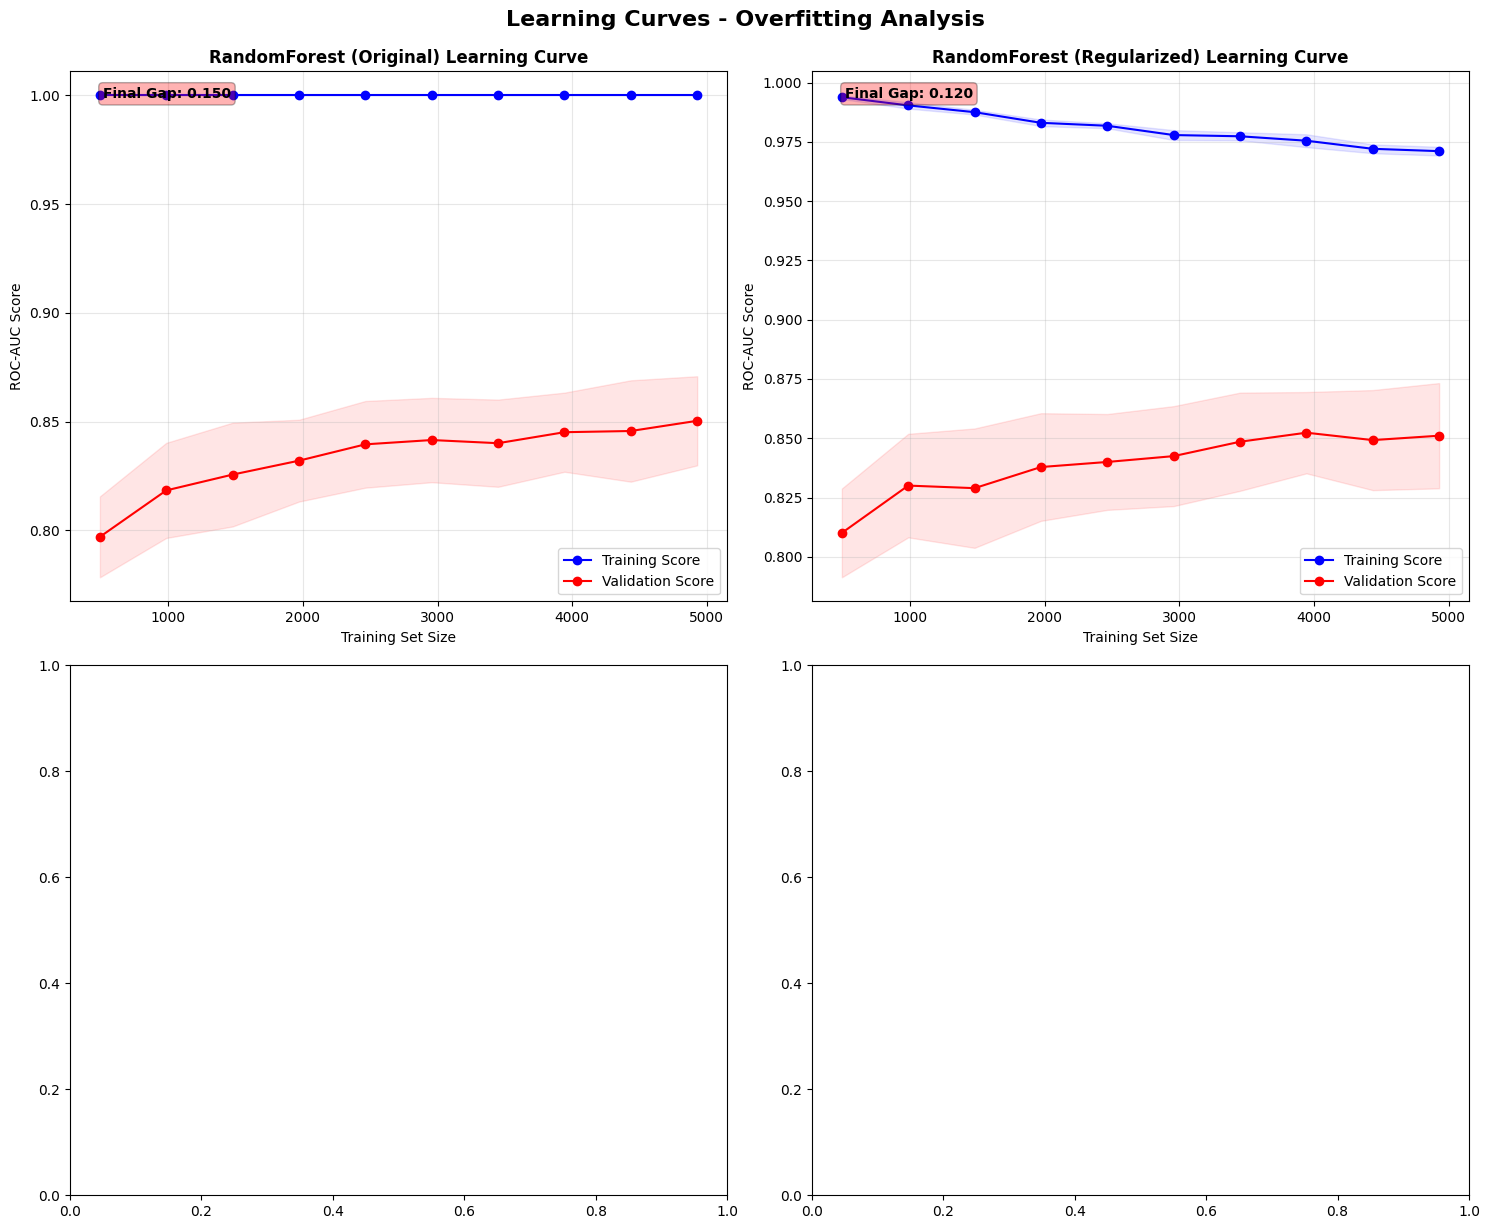


📊 LEARNING CURVE ANALYSIS COMPLETED!
🔍 Look for:
  - Large gaps between training and validation curves (overfitting)
  - Convergence patterns
  - Regularized vs Original model differences

💡 VALIDATION STRATEGY RECOMMENDATIONS:
1. 📊 Use Stratified K-Fold Cross-Validation (10 folds)
2. 🎯 Monitor both training and validation metrics
3. ⚡ Early stopping for tree-based models
4. 🎛️  Hyperparameter tuning with regularization
5. 📈 Feature selection to reduce complexity
6. 🔄 Ensemble methods with diversity
7. 📉 Learning rate scheduling
8. 🎲 Data augmentation techniques

🎯 NEXT STEPS TO REDUCE OVERFITTING:
----------------------------------------
✅ Run regularized models
✅ Analyze learning curves
🔄 Implement early stopping
🔄 Feature selection analysis
🔄 Cross-validation with more folds
🔄 Ensemble diversity analysis


In [14]:
# 11. LEARNING CURVES ANALİZİ

print("📈 LEARNING CURVES ANALYSIS")
print("=" * 50)

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curves(models_dict, X, y, cv=5):
    """
    Learning curves çizerek overfitting'i görselleştir
    """
    n_models = len(models_dict)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models_dict.items()):
        if idx >= 4:  # Maksimum 4 model göster
            break
            
        try:
            # Learning curve hesapla
            train_sizes, train_scores, val_scores = learning_curve(
                model, X, y, cv=cv, 
                train_sizes=np.linspace(0.1, 1.0, 10),
                scoring='roc_auc', n_jobs=-1, random_state=42
            )
            
            # Ortalama ve standart sapma hesapla
            train_mean = np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            val_mean = np.mean(val_scores, axis=1)
            val_std = np.std(val_scores, axis=1)
            
            # Grafik çiz
            ax = axes[idx]
            ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
            ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
            
            ax.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
            ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
            
            ax.set_title(f'{name} Learning Curve', fontsize=12, fontweight='bold')
            ax.set_xlabel('Training Set Size')
            ax.set_ylabel('ROC-AUC Score')
            ax.legend(loc='lower right')
            ax.grid(True, alpha=0.3)
            
            # Overfitting analizi
            final_gap = train_mean[-1] - val_mean[-1]
            gap_color = 'red' if final_gap > 0.1 else 'orange' if final_gap > 0.05 else 'green'
            ax.text(0.05, 0.95, f'Final Gap: {final_gap:.3f}', 
                   transform=ax.transAxes, fontweight='bold', 
                   bbox=dict(boxstyle='round', facecolor=gap_color, alpha=0.3))
            
            print(f"✅ {name} learning curve completed - Final gap: {final_gap:.4f}")
            
        except Exception as e:
            print(f"❌ Error plotting {name}: {e}")
            continue
    
    # Boş subplot'ları gizle
    for idx in range(len(models_dict), 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Learning Curves - Overfitting Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    return fig

# Model comparison için learning curves
if 'X_train_scaled' in locals():
    print("\n🎯 GENERATING LEARNING CURVES...")
    print("-" * 50)
    
    # Model karşılaştırması için seçili modeller
    comparison_models = {
        'RandomForest (Original)': RandomForestClassifier(random_state=42, n_jobs=-1),
        'RandomForest (Regularized)': RandomForestClassifier(
            random_state=42, n_jobs=-1, max_depth=10, 
            min_samples_split=10, min_samples_leaf=5
        ),
        'XGBoost (Original)': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'XGBoost (Regularized)': xgb.XGBClassifier(
            random_state=42, eval_metric='logloss',
            reg_alpha=1.0, reg_lambda=1.0, max_depth=4, learning_rate=0.05
        )
    }
    
    # Learning curves çiz
    fig = plot_learning_curves(comparison_models, X_train_scaled, y_train, cv=5)
    
    print("\n📊 LEARNING CURVE ANALYSIS COMPLETED!")
    print("🔍 Look for:")
    print("  - Large gaps between training and validation curves (overfitting)")
    print("  - Convergence patterns")
    print("  - Regularized vs Original model differences")
    
else:
    print("⚠️ Data not loaded. Please run the data loading cell first.")

# Validasyon stratejisi önerileri
print("\n💡 VALIDATION STRATEGY RECOMMENDATIONS:")
print("=" * 50)
print("1. 📊 Use Stratified K-Fold Cross-Validation (10 folds)")
print("2. 🎯 Monitor both training and validation metrics")
print("3. ⚡ Early stopping for tree-based models")
print("4. 🎛️  Hyperparameter tuning with regularization")
print("5. 📈 Feature selection to reduce complexity")
print("6. 🔄 Ensemble methods with diversity")
print("7. 📉 Learning rate scheduling")
print("8. 🎲 Data augmentation techniques")

print("\n🎯 NEXT STEPS TO REDUCE OVERFITTING:")
print("-" * 40)
print("✅ Run regularized models")
print("✅ Analyze learning curves")
print("🔄 Implement early stopping")
print("🔄 Feature selection analysis")
print("🔄 Cross-validation with more folds")
print("🔄 Ensemble diversity analysis")